# -0.5ψ'' + 0.5*x^2*ψ - E*ψ = 0

Epoch 0: Loss = 1.535532, E = 0.501000
Epoch 1000: Loss = 0.000023, E = 0.527582
Epoch 2000: Loss = 0.000005, E = 0.523295
Epoch 3000: Loss = 0.000002, E = 0.518907
Epoch 4000: Loss = 0.000001, E = 0.515392
Epoch 5000: Loss = 0.000340, E = 0.512438
Epoch 6000: Loss = 0.000000, E = 0.510890
Epoch 7000: Loss = 0.000000, E = 0.509377
Epoch 8000: Loss = 0.000001, E = 0.508035
Epoch 9000: Loss = 0.000723, E = 0.507044
Training completed.


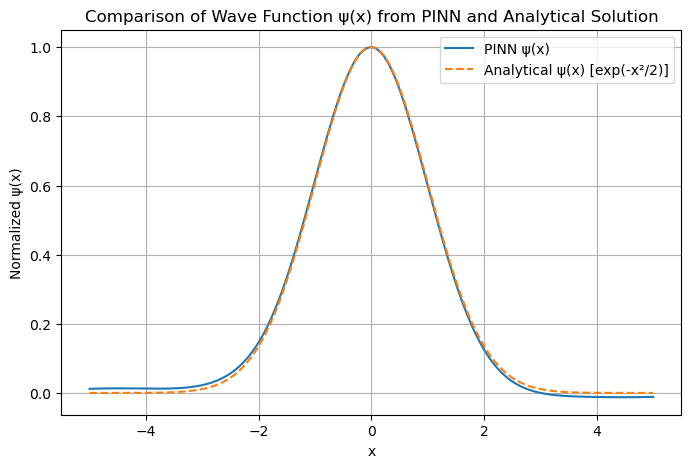

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the Quantum PINN model
class QuantumPINN(nn.Module):
    def __init__(self):
        super(QuantumPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Define the energy E as a learnable parameter
        self.E = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        return self.net(x)

# Define the residual of the Schrödinger equation
def schrodinger_residual(model, x):
    # Ensure x requires gradient for differentiation
    x.requires_grad = True
    psi = model(x)
    # Compute the first derivative dψ/dx
    psi_x = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    # Compute the second derivative d²ψ/dx²
    psi_xx = torch.autograd.grad(psi_x, x, grad_outputs=torch.ones_like(psi_x), create_graph=True)[0]
    # Residual: -0.5ψ'' + 0.5*x^2*ψ - E*ψ = 0
    residual = -0.5 * psi_xx + 0.5 * x**2 * psi - model.E * psi
    return residual

# Generate collocation points for the domain
x_collocation = torch.linspace(-5, 5, 100).view(-1, 1)
# Define boundary points
x_boundary = torch.tensor([[-5.0], [5.0]])

# Initialize the model and optimizer
model = QuantumPINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute the residual loss of the Schrödinger equation
    res = schrodinger_residual(model, x_collocation)
    loss_res = torch.mean(res**2)

    # Boundary condition loss: enforce ψ(-5)=ψ(5)=0
    psi_boundary = model(x_boundary)
    loss_bc = torch.mean(psi_boundary**2)

    # Total loss
    loss = loss_res + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}, E = {model.E.item():.6f}")

print("Training completed.")

# Prepare plotting domain
x_plot = torch.linspace(-5, 5, 200).view(-1, 1)
model.eval()  # Set model to evaluation mode
psi_pinn = model(x_plot).detach().numpy()

# Analytical ground state wavefunction for the quantum harmonic oscillator (unnormalized)
x_np = x_plot.numpy()
psi_analytical = np.exp(-0.5 * x_np**2)

# Normalize both wave functions for better comparison
psi_pinn_norm = psi_pinn / np.max(np.abs(psi_pinn))
psi_analytical_norm = psi_analytical / np.max(np.abs(psi_analytical))

# Plot the PINN wave function and the analytical solution
plt.figure(figsize=(8, 5))
plt.plot(x_np, psi_pinn_norm, label='PINN ψ(x)')
plt.plot(x_np, psi_analytical_norm, '--', label='Analytical ψ(x) [exp(-x²/2)]')
plt.xlabel('x')
plt.ylabel('Normalized ψ(x)')
plt.title('Comparison of Wave Function ψ(x) from PINN and Analytical Solution')
plt.legend()
plt.grid(True)
plt.show()


# u''(x) + π^2 sin(πx) = 0

Epoch 0, Loss: 49.28055953979492
Epoch 500, Loss: 0.19265252351760864
Epoch 1000, Loss: 0.0006481575546786189
Epoch 1500, Loss: 0.00012661184882745147


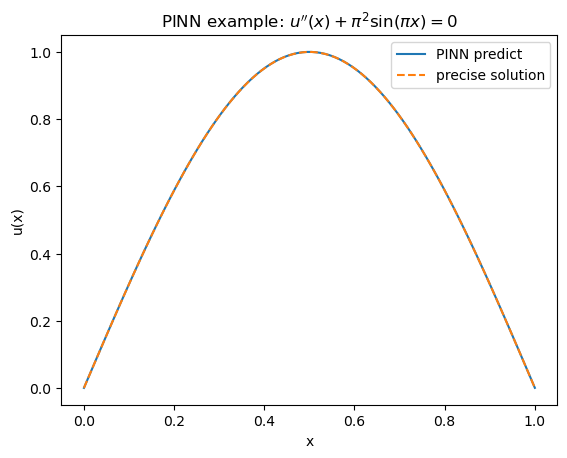

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.hidden(x)

def compute_derivatives(model, x):
    x.requires_grad_(True)
    u = model(x)
    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
    return u, du_dx, d2u_dx2

def pinn_loss(model, x_interior, x_boundary):
    # u''(x) + π^2 sin(πx) = 0
    u, du_dx, d2u_dx2 = compute_derivatives(model, x_interior)
    f = d2u_dx2 + (torch.pi**2) * torch.sin(torch.pi * x_interior)
    interior_loss = torch.mean(f**2)

    # u(0)=0, u(1)=0
    u_b = model(x_boundary)
    boundary_loss = torch.mean(u_b**2)

    return interior_loss + boundary_loss

model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    x_interior = torch.linspace(0, 1, 100).view(-1, 1)
    x_boundary = torch.tensor([[0.0], [1.0]])

    loss = pinn_loss(model, x_interior, x_boundary)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

x_test = torch.linspace(0, 1, 100).view(-1, 1)
u_pred = model(x_test).detach().numpy()

import matplotlib.pyplot as plt
import numpy as np

x_test_np = x_test.numpy()
u_exact = np.sin(np.pi * x_test_np)

plt.figure()
plt.plot(x_test_np, u_pred, label="PINN predict")
plt.plot(x_test_np, u_exact, label="precise solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("PINN example: $ u''(x) + \\pi^2 \\sin(\\pi x)=0$")
plt.show()
